In [221]:
### import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import warnings
warnings.filterwarnings(action='ignore')

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.1563 - val_loss: 0.0071
Epoch 2/200
1/1 [==============================] - 0s 115ms/step - loss: 0.0739 - val_loss: 2.9909e-04
Epoch 3/200
1/1 [==============================] - 0s 68ms/step - loss: 0.1005 - val_loss: 0.0104
Epoch 4/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0616 - val_loss: 0.0318
Epoch 5/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0682 - val_loss: 0.0466
Epoch 6/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0952 - val_loss: 0.0562
Epoch 7/200
1/1 [==============================] - 0s 61ms/step - loss: 0.1085 - val_loss: 0.0638
Epoch 8/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0848 - val_loss: 0.0553
Epoch 9/200
1/1 [==============================] - 0s 53ms/step - loss: 0.1522 - val_loss: 0.0398
Epoch 10/200
1/1 [==============================] - 0s 40ms/step - loss: 0.1215 - val_loss: 0.0250
Epoch 11/200
1/1

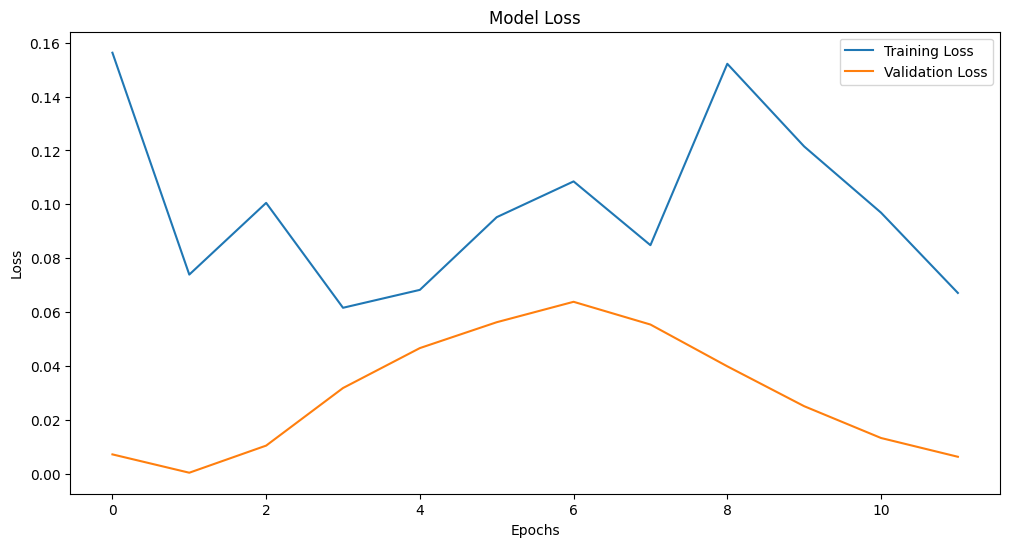

1/1 [==============================] - 0s 23ms/step


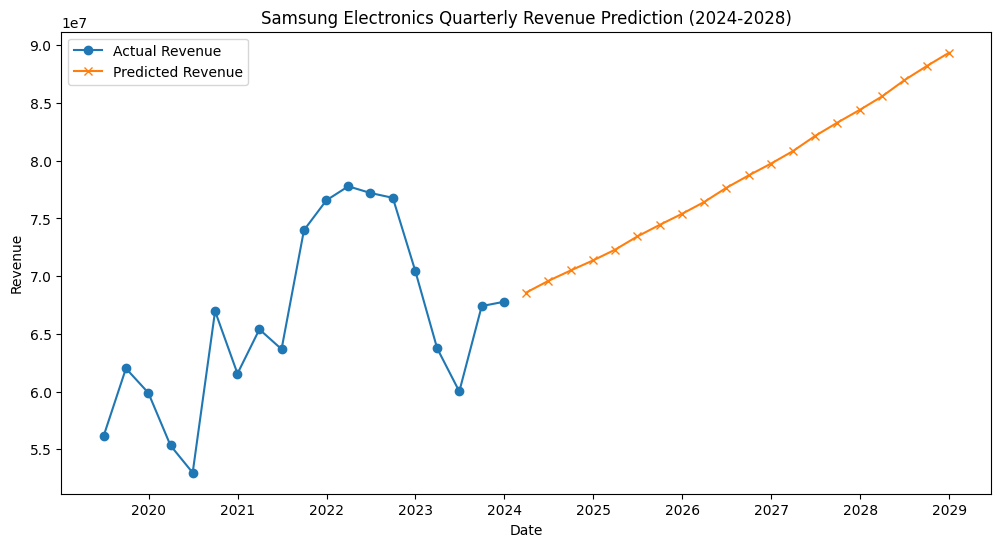

           ds          yhat
0  2024-03-31  6.857888e+07
1  2024-06-30  6.959103e+07
2  2024-09-30  7.049601e+07
3  2024-12-31  7.136857e+07
4  2025-03-31  7.229443e+07
5  2025-06-30  7.343614e+07
6  2025-09-30  7.444216e+07
7  2025-12-31  7.540249e+07
8  2026-03-31  7.641445e+07
9  2026-06-30  7.764186e+07
10 2026-09-30  7.872239e+07
11 2026-12-31  7.974804e+07
12 2027-03-31  8.083124e+07
13 2027-06-30  8.214382e+07
14 2027-09-30  8.330549e+07
15 2027-12-31  8.440920e+07
16 2028-03-31  8.556857e+07
17 2028-06-30  8.696461e+07
18 2028-09-30  8.819258e+07
19 2028-12-31  8.935603e+07


In [244]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 데이터 로드 및 준비
file_path = '기업정보.xlsx'
data = pd.read_excel(file_path, header=1)

# 매출액 데이터 추출 및 전처리
sales = data['매출액'][::-1].dropna().values
dates = pd.date_range(start='2019-01-01', periods=len(sales), freq='Q')
df = pd.DataFrame({'ds': dates, 'y': sales})
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/mnt/data/lstm_model.h5', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=16, callbacks=[early_stop, model_checkpoint])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 로드
loaded_model = tf.keras.models.load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-01-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


In [346]:
### import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import warnings
warnings.filterwarnings(action='ignore')

In [347]:
### DB에서 재무데이터 불러오기 
def load_FS():

        company = input("종목코드를 입력하세요: ")
        table = pd.read_excel('기업정보.xlsx', header=1, sheet_name=company)
        table = table.iloc[:,1:]
        print(table.head())

        return company, table

In [348]:
### 과거 5개년치 분기별 FCFF데이터 전처리
class step1:
    
    def __init__(self, company, table):
        self._company = company
        self._table = table
        self._tax = 0
        self._sales = [] 
        self._cogs = []
        self._sgna = []
        self._op = []
        self._capex_l = []
        self._dep_l = []
        self._amo_l = []
        self._dNWC = [0]
        self._FCFF = []
        self._NWC = [] 
    
    def Basic_IS(self):
        
        self._sales = self._table['매출액'][::-1].dropna().values / 100 
        self._cogs = self._table['매출원가'][::-1].dropna().values / 100
        self._sgna = self._table['판매관리비'][::-1].dropna().values / 100
        self._tax = self._table['법인세율'][::-1].dropna().values / 100 

        for i in range(20):
            self._op.append((self._sales[i]-self._cogs[i]-self._sgna[i])*(1-self._tax[i]))

        return self._tax
    
    def Basic_CF(self):

        self._capex_l = self._table['자본적지출'][::-1].dropna().values / 100
        self._dep_l = self._table['유형자산감가상각비'][::-1].dropna().values / 100
        self._amo_l = self._table['무형자산감가상각비'][::-1].dropna().values / 100
    
    def Dnwc(self):

        self._NWC = self._table['순운전자본'][::-1].dropna().values[1:] / 100
        self._dNWC = self._table['순운전자본증감'][::-1].dropna().values / 100
 
    def FCFF(self):
    
        for i in range(20):
            self._FCFF.append(self._op[i]+self._dep_l[i]+self._amo_l[i]-self._capex_l[i]-self._dNWC[i])

    def mktable(self):
        
        d_main_info = {'매출액': self._sales,'매출원가': self._cogs,'판관비': self._sgna
                 ,'영업이익': self._op,'+유형자산상각비':self._dep_l,'+무형자산상각비': self._amo_l,
                   '-Capex': self._capex_l,'-dNwc': self._dNWC, 'FCFF': self._FCFF, '참고용NWC': self._NWC}
        
      
        # 2019년 1분기부터 2023년 4분기까지의 분기 생성
        quarters = []
        for year in range(2019, 2024):
            for q in range(1, 5):
                quarters.append(f"{year}-Q{q}")

        # 각 리스트의 길이가 20인지 확인
        for key, value in d_main_info.items():
            if len(value) != 20:
                raise ValueError(f"{key} 리스트의 길이가 20이 아닙니다. 현재 길이: {len(value)}")

        Main_info = pd.DataFrame(d_main_info, index=quarters)

        S_BS = Main_info.transpose()
        print("최근 5개년 분기별 FCFF(단위: 억)")
        display(S_BS)
        print("첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음\n ")
        return S_BS


In [349]:
# Step1 : loading F/S
FS1_tables = load_FS()
company = FS1_tables[0]
table = FS1_tables[1]

asset1 = step1(company, table)
tax = asset1.Basic_IS()
asset1.Basic_CF()
asset1.Dnwc()
asset1.FCFF()
fcff_table = asset1.mktable()

     분기         매출액        매출원가       판매관리비       영업이익   법인세율       세후영업이익  \
0  23-4  67779938.0  46115571.0  18839650.0  2824717.0  0.275  2047919.825   
1  23-3  67404652.0  46618726.0  18352392.0  2433534.0  0.275  1764312.150   
2  23-2  60005533.0  41647190.0  17689796.0   668547.0  0.275   484696.575   
3  23-1  63745371.0  46007093.0  17098100.0   640178.0  0.275   464129.050   
4  22-4  70464575.0  48627728.0  17530716.0  4306131.0  0.275  3121944.975   

   유형자산감가상각비  무형자산감가상각비       자본적지출     순운전자본증감          FCFF       유동자산  \
0  9063346.0   771036.0  16629676.0 -12596315.0  7.848941e+06  195936557   
1  8900426.0   786661.0  11987374.0   -381315.0 -1.546598e+05  206438600   
2  8767744.0   790853.0  14955979.0  -5189958.0  2.772726e+05  203975373   
3  8800895.0   785598.0  11343333.0  -1741036.0  4.483251e+05  214442141   
4  8843137.0   805921.0  21125529.0 -25469239.0  1.711471e+07  218470581   

       유동부채      순운전자본           자산           자본          부채        비유동자산 

,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,2022-Q1,2022-Q2,2022-Q3,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4
매출액,5.238555e+05,5.612710e+05,6.200347e+05,5.988476e+05,5.532518e+05,5.296614e+05,6.696416e+05,6.155151e+05,6.538850e+05,6.367158e+05,7.397919e+05,7.656552e+05,7.778150e+05,7.720361e+05,7.678168e+05,7.046458e+05,6.374537e+05,6.000553e+05,6.740465e+05,6.777994e+05
매출원가,3.274645e+05,3.594468e+05,3.999389e+05,3.855452e+05,3.480669e+05,3.190620e+05,3.997048e+05,3.780493e+05,4.149998e+05,3.706593e+05,4.289887e+05,4.494655e+05,4.707206e+05,4.626975e+05,4.807224e+05,4.862773e+05,4.600709e+05,4.164719e+05,4.661873e+05,4.611557e+05
판관비,1.340581e+05,1.358535e+05,1.423169e+05,1.416997e+05,1.407114e+05,1.291365e+05,1.464045e+05,1.469958e+05,1.450565e+05,1.403891e+05,1.526279e+05,1.775226e+05,1.658803e+05,1.683681e+05,1.785740e+05,1.753072e+05,1.709810e+05,1.768980e+05,1.835239e+05,1.883965e+05
영업이익,6.216140e+04,6.578923e+04,7.756503e+04,7.140579e+04,6.429615e+04,8.123890e+04,1.231927e+05,9.022122e+04,9.357065e+04,1.253219e+05,1.577403e+05,1.382858e+05,1.408258e+05,1.405828e+05,1.082220e+05,4.294289e+04,6.384175e+03,6.667085e+03,2.426842e+04,2.816949e+04
+유형자산상각비,6.840816e+04,6.640252e+04,6.545815e+04,6.546933e+04,6.591167e+04,6.608388e+04,6.835367e+04,7.080813e+04,7.147736e+04,7.213089e+04,8.059814e+04,8.864570e+04,9.009031e+04,9.068814e+04,9.031116e+04,8.843137e+04,8.800895e+04,8.767744e+04,8.900426e+04,9.063346e+04
+무형자산상각비,2.547280e+03,2.504480e+03,3.217450e+03,2.196901e+04,8.144380e+03,8.099410e+03,8.000670e+03,7.954350e+03,6.955420e+03,7.763130e+03,7.530350e+03,7.372620e+03,7.704770e+03,7.725520e+03,8.066110e+03,8.059210e+03,7.855980e+03,7.908530e+03,7.866610e+03,7.710360e+03
-Capex,4.709517e+04,6.512102e+04,6.453743e+04,1.034472e+05,7.528089e+04,9.929008e+04,8.753644e+04,1.320087e+05,1.017611e+05,1.387980e+05,1.021671e+05,1.569254e+05,8.098867e+04,1.265554e+05,1.334703e+05,2.112553e+05,1.134333e+05,1.495598e+05,1.198737e+05,1.662968e+05
-dNwc,4.418519e+04,4.089774e+04,8.614735e+04,-5.136446e+04,4.373962e+04,2.296666e+04,6.315384e+04,-7.977280e+04,-3.565337e+04,-3.888180e+03,1.226398e+05,-8.750030e+03,1.185933e+05,1.101984e+05,1.266974e+05,-2.546924e+05,-1.741036e+04,-5.189958e+04,-3.813150e+03,-1.259631e+05
FCFF,4.183648e+04,2.867747e+04,-4.444152e+03,1.067614e+05,1.933169e+04,3.316545e+04,4.885673e+04,1.167478e+05,1.058957e+05,7.030609e+04,2.106185e+04,8.612872e+04,3.903887e+04,2.242641e+03,-5.356842e+04,1.828706e+05,6.226135e+03,4.592845e+03,5.078698e+03,8.617970e+04
참고용NWC,1.100344e+06,1.141242e+06,1.227389e+06,1.176025e+06,1.219765e+06,1.242731e+06,1.305885e+06,1.226112e+06,1.190459e+06,1.186571e+06,1.309211e+06,1.300461e+06,1.419054e+06,1.529252e+06,1.655950e+06,1.401257e+06,1.383847e+06,1.331947e+06,1.328134e+06,1.202171e+06


첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음
 


In [350]:
### 5개년치 추정
class step2:

    def __init__(self, table, tax):
        
        self._table = table.transpose()
        self._tax = tax
        self._pred_sales = []
        self._cagr =  0
        self._cogs_avg = 0
        self._sgna_avg = 0
        self._capex_ratio = 0
        self._dep_ratio = 0
        self._amo_ratio = 0
        self._NWC_ratio = 0


    def salesForcast(self):
       
        import pandas as pd
        import numpy as np
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.model_selection import train_test_split
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        import matplotlib.pyplot as plt


        # 매출액 데이터 추출 및 전처리
        sales = self._table['매출액'].values 
        dates = pd.date_range(start='2019-01-01', periods=len(sales), freq='Q')
        df = pd.DataFrame({'ds': dates, 'y': sales})
        df.set_index('ds', inplace=True)

        # 성장률 계산
        df['growth_rate'] = df['y'].pct_change()

        # 분기 정보를 추가하여 계절성을 반영
        df['quarter'] = df.index.quarter

        # 성장률 예측을 위한 데이터 준비
        df.dropna(inplace=True)  # NaN 값 제거
        scaler = MinMaxScaler()
        df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

        sequence_length = 16  # 시퀀스 길이 조정
        X, y = [], []

        for i in range(len(df) - sequence_length):
            X_seq = df['growth_rate'].values[i:i + sequence_length]
            quarter_seq = df['quarter'].values[i:i + sequence_length]
            X.append(np.column_stack((X_seq, quarter_seq)))
            y.append(df['growth_rate'].values[i + sequence_length])

        X = np.array(X)
        y = np.array(y)
        '''
        # 훈련 세트와 검증 세트로 나누기
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

        # 모델 생성
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(sequence_length, 2)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

        # EarlyStopping 콜백 추가
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('/mnt/data/lstm_model.h5', monitor='val_loss', save_best_only=True)

        # 모델 학습
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=16, callbacks=[early_stop, model_checkpoint])

        # 학습 과정 시각화
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        '''
        # 모델 로드
        loaded_model = tf.keras.models.load_model('/mnt/data/lstm_model.h5')

        # 2024년부터 2028년까지의 분기별 성장률 예측
        future_growth_rates = []
        current_sequence = X[-1].reshape((1, sequence_length, 2))

        # 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
        base_growth_rate = 0.005

        for i in range(20):  # 5년 * 4분기 = 20분기 예측
            predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
            # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
            adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
            future_growth_rates.append(adjusted_growth_rate)
            next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
            current_sequence = next_sequence.reshape((1, sequence_length, 2))

        # 예측된 성장률 반전 정규화
        future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

        # 매출액이 항상 증가하도록 보정
        last_revenue = df['y'].values[-1]
        future_revenues = []

        for growth_rate in future_growth_rates.flatten():
            next_revenue = last_revenue * (1 + growth_rate)
            future_revenues.append(next_revenue)
            last_revenue = next_revenue

        # 예측 결과 데이터프레임 생성
        future_dates = pd.date_range(start='2024-01-01', periods=20, freq='Q')
        future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})
        

        # 예측 결과 시각화
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
        plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
        plt.xlabel('Date')
        plt.ylabel('Revenue')
        plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
        plt.legend()
        plt.show()

        # 예측된 매출 출력
        print(future_df[['ds', 'yhat']])

        print(future_df['yhat'].values)

        self.F_sales = future_df['yhat'].values


    def ratios(self):
        
        for i in range(20):
            self._cogs_avg += self._table['매출원가'][i] / self._table['매출액'][i]/20
            self._sgna_avg += self._table['판관비'][i] / self._table['매출액'][i]/20
            self._capex_ratio += self._table['-Capex'][i] / self._table['매출액'][i]/20
            self._dep_ratio += self._table['+유형자산상각비'][i] / self._table['매출액'][i]/20
            self._amo_ratio += self._table['+무형자산상각비'][i] / self._table['매출액'][i]/20
            self._NWC_ratio += self._table['참고용NWC'][i] / self._table['매출액'][i]/20
        

        print("매출원가", self._cogs_avg)
        print("판관비", self._sgna_avg)
        print("자본적지출", self._capex_ratio)
        print("유형상각", self._dep_ratio)
        print("무형상각", self._amo_ratio)
        print("순운전자본", self._NWC_ratio)

    def forecast(self):
        
        F_sales = self.F_sales
        F_cogs = []
        F_sgna = []
        F_op = []
        F_capex = []
        F_dep = []
        F_amo = []
        F_dnwc = []
        F_FCFF = []
        F_NWC = []

        last_NWC = self._table['참고용NWC'][-1] / 100  # 2023-Q4의 순운전자본
        print(last_NWC)

        for i in range(20):
            F_cogs_val = np.round(F_sales[i] * self._cogs_avg, 1)
            F_sgna_val = np.round(F_sales[i] * self._sgna_avg, 1)
            F_op_val = np.round((F_sales[i] - F_cogs_val - F_sgna_val) * (1 - self._tax), 1)
            F_capex_val = np.round(F_sales[i] * self._capex_ratio, 1)
            F_dep_val = np.round(F_sales[i] * self._dep_ratio, 1)
            F_amo_val = np.round(F_sales[i] * self._amo_ratio, 1)
            F_NWC_val = np.round(F_op_val * self._NWC_ratio, 1)

            if i == 0:
                F_dnwc_val = np.round(F_NWC_val - last_NWC, 1)
            else:
                F_dnwc_val = np.round(F_NWC_val - F_NWC[i-1], 1)

            F_FCFF_val = np.round(F_op_val + F_dep_val + F_amo_val - F_capex_val - F_dnwc_val, 1)

            F_cogs.append(F_cogs_val)
            F_sgna.append(F_sgna_val)
            F_op.append(F_op_val)
            F_capex.append(F_capex_val)
            F_dep.append(F_dep_val)
            F_amo.append(F_amo_val)
            F_NWC.append(F_NWC_val)
            F_dnwc.append(F_dnwc_val)
            F_FCFF.append(F_FCFF_val)
        
        F_op = [np.mean(arr) for arr in F_op]
        F_dnwc = [np.mean(arr) for arr in F_dnwc]
        F_FCFF = [np.mean(arr) for arr in F_FCFF]

        dFIS = {
            '매출액': F_sales,
            '매출원가': F_cogs,
            '판관비': F_sgna,
            '영업이익': F_op,
            '+유형자산상각비': F_dep,
            '+무형자산상각비': F_amo,
            '-Capex': F_capex,
            '-dNwc': F_dnwc,
            'FCFF': F_FCFF
        }
        
        # 2024년 1분기부터 2028년 4분기까지의 분기 생성
        quarters = []
        for year in range(2024, 2029):
            for q in range(1, 5):
                quarters.append(f"{year}-Q{q}")

        # 각 리스트의 길이가 20인지 확인
        for key, value in dFIS.items():
            if len(value) != 20:
                raise ValueError(f"{key} 리스트의 길이가 20이 아닙니다. 현재 길이: {len(value)}")

        ISFt = pd.DataFrame(dFIS, index=quarters)

        FIS = ISFt.transpose()
        print("미래 5개년 분기별 FCFF(단위: 억)")
        display(FIS)
        print("첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음\n ")
        return FIS


1/1 [==============================] - 0s 19ms/step


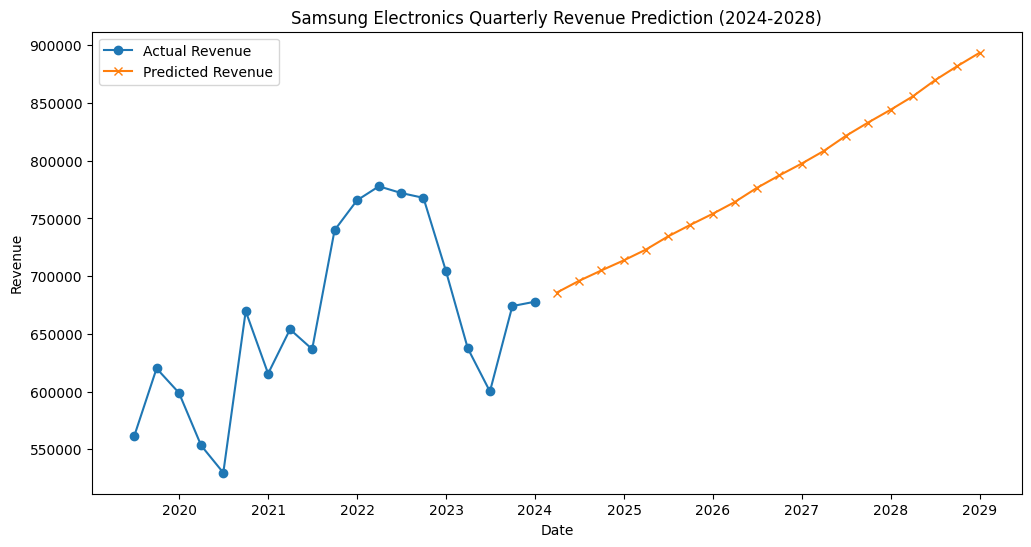

           ds           yhat
0  2024-03-31  685788.811574
1  2024-06-30  695910.337617
2  2024-09-30  704960.143809
3  2024-12-31  713685.666904
4  2025-03-31  722944.337859
5  2025-06-30  734361.402814
6  2025-09-30  744421.611002
7  2025-12-31  754024.940602
8  2026-03-31  764144.474065
9  2026-06-30  776418.638585
10 2026-09-30  787223.889046
11 2026-12-31  797480.441242
12 2027-03-31  808312.440422
13 2027-06-30  821438.218517
14 2027-09-30  833054.929046
15 2027-12-31  844092.016834
16 2028-03-31  855685.715843
17 2028-06-30  869646.147124
18 2028-09-30  881925.773000
19 2028-12-31  893560.324129
[685788.81157434 695910.33761651 704960.14380866 713685.66690426
 722944.33785874 734361.40281426 744421.61100216 754024.94060151
 764144.47406479 776418.63858508 787223.88904554 797480.44124223
 808312.44042245 821438.21851657 833054.9290463  844092.01683406
 855685.71584326 869646.14712418 881925.77300046 893560.32412921]
매출원가 0.6344586526214989
판관비 0.24130777622538407
자본적지출 0.173010606

,2024-Q1,2024-Q2,2024-Q3,2024-Q4,2025-Q1,2025-Q2,2025-Q3,2025-Q4,2026-Q1,2026-Q2,2026-Q3,2026-Q4,2027-Q1,2027-Q2,2027-Q3,2027-Q4,2028-Q1,2028-Q2,2028-Q3,2028-Q4
매출액,685788.811574,695910.337617,704960.143809,713685.666904,722944.337859,734361.402814,744421.611002,754024.940602,764144.474065,776418.638585,787223.889046,797480.441242,808312.440422,821438.218517,833054.929046,844092.016834,855685.715843,869646.147124,881925.773,893560.324129
매출원가,435104.600000,441526.300000,447268.100000,452804.000000,458678.300000,465921.900000,472304.700000,478397.600000,484818.100000,492605.500000,499461.000000,505968.400000,512840.800000,521168.600000,528538.900000,535541.500000,542897.200000,551754.500000,559545.400,566927.100000
판관비,165486.200000,167928.600000,170112.400000,172217.900000,174452.100000,177207.100000,179634.700000,181952.100000,184394.000000,187355.900000,189963.200000,192438.200000,195052.100000,198219.400000,201022.600000,203686.000000,206483.600000,209852.400000,212815.500,215623.100000
영업이익,84963.700000,86217.700000,87338.800000,88419.900000,89566.900000,90981.500000,92227.900000,93417.600000,94671.300000,96192.000000,97530.700000,98801.400000,100143.400000,101769.600000,103208.800000,104576.100000,106012.600000,107742.100000,109263.600,110704.800000
+유형자산상각비,82242.500000,83456.300000,84541.600000,85588.000000,86698.300000,88067.500000,89274.000000,90425.600000,91639.200000,93111.200000,94407.000000,95637.000000,96936.000000,98510.100000,99903.200000,101226.800000,102617.200000,104291.400000,105764.000,107159.200000
+무형자산상각비,8199.500000,8320.500000,8428.700000,8533.000000,8643.700000,8780.200000,8900.500000,9015.300000,9136.300000,9283.100000,9412.300000,9534.900000,9664.400000,9821.300000,9960.200000,10092.200000,10230.800000,10397.700000,10544.500,10683.600000
-Capex,118648.700000,120399.900000,121965.600000,123475.200000,125077.000000,127052.300000,128792.800000,130454.300000,132205.100000,134328.700000,136198.100000,137972.600000,139846.600000,142117.500000,144127.300000,146036.900000,148042.700000,150458.000000,152582.500,154595.400000
-dNwc,157089.200000,2495.900000,2231.500000,2151.800000,2282.900000,2815.600000,2480.900000,2367.900000,2495.400000,3026.800000,2664.500000,2529.200000,2671.100000,3236.800000,2864.500000,2721.500000,2859.200000,3442.400000,3028.400,2868.500000
FCFF,-100332.200000,55098.700000,56112.000000,56913.900000,57549.000000,57961.300000,59128.700000,60036.300000,60746.300000,61230.800000,62487.400000,63471.500000,64226.100000,64746.700000,66080.400000,67136.700000,67958.700000,68530.800000,69961.200,71083.700000


첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음
 


In [351]:
 # Step2 : Forecasting
asset1 = step2(fcff_table, tax)
asset1.salesForcast()
asset1.ratios()
forecast = asset1.forecast()

In [352]:
class WACC:
    
    print("\n__________________________________________________________________________________________")
    print("WACC는 가중평균 자본비용으로 미래 가치들에 대한 할인율로 이용된다.")
    
    def __init__(self, company, table, tax):
        
        self._company = company
        self._table = table
        self._tax = tax
        self._Rf = 0
        self._Rm = 0
        self._beta = 0
        self._kd = 0
        self._ke = 0 

    def risk_free_rate(self):
        
        # 연도별로 xlsx 업데이트 필요 (2019~2023)
        #'https://www.index.go.kr/unity/potal/main/EachDtlPageDetail.do?idx_cd=1073#'
        tables = pd.read_excel('2024국고채.xlsx')
        rf_r = tables.iloc[3:4, 4:9]
        b5y = rf_r.values.flatten().tolist()

        # 국고채 5년 수익률의 가중평균
        for i in range(len(b5y)):
            self._Rf += b5y[i]/len(b5y)

        self._Rf = round(self._Rf/100,4)
        print("Rf : 무위험 수익률")
        print("한국 국고채 5년 평균 수익률: {}%\n".format(str(round(self._Rf*100,3))))
        return self._Rf


    def market_risk_premium(self):

        KOSPI = yf.download('^KS11', start="2019-01-01",end="2023-12-31")['Adj Close']
        returns = KOSPI.pct_change()

        self._Rm = round(returns.mean() * 252, 3)

        print("Rm : 시장 수익률")
        print("KOSPI 5년 평균 수익률: {}%\n".format(str(round(self._Rm*100,3))))
        
        return self._Rm


        '''
        # 연도별로 xlsx 업데이트 필요 (2019~2023)
        #'https://finance.yahoo.com/quote/%5EKS11/history?frequency=1mo&period1=1557132568&period2=1714985072'
        
        tables = pd.read_csv('/Users/hw/서강대학부자료/Quantifi/금융보고서스터디/24코스피.csv')

        tables['pct_year'] = tables['Close'].pct_change()
        
        # 일별수익률의 평균을 구한 후 연수익률로 환산
        self._Rm = round(tables['pct_year'].mean() * 252, 3)
        
        print("Rm : 시장 수익률")
        print("KOSPI 5년 평균 수익률: {}%\n".format(str(round(self._Rm*100,3))))
        return self._Rm
        '''
        
    def beta(self):
        
        tickers = ['^KS11', self._company + '.KS']

        price = pd.DataFrame()
        for items in tickers:
            price[items] = yf.download(items, start="2019-01-01",end="2023-12-31")['Adj Close']

        returns = price.pct_change()
        
        covs = returns.cov()
        covs = covs.loc['^KS11', self._company + '.KS']

        import math
        var_KOSPI = returns['^KS11'].var()

        self._beta = covs / var_KOSPI
        
        print("Beta : 회사주가와 시장지수의 상관계수")
        print("Leverd Beta: {}\n".format(self._beta))
        
        
        print(">>>>Re(자기자본비용) = Rf + Beta(Rm-Rf)\n\n ")
        return self._beta

    # 신용등급을 직접입력하는...    
    '''
    def cost_debt(self):
        
        source_url = 'https://www.kisrating.com/ratingsStatistics/statics_spread.do'
        tables = pd.read_html(source_url, encoding='utf-8')
        self._kd_r = tables[0]
        self._kd_r.index = list(self._kd_r.iloc[:,0])
        self._kd_r = self._kd_r.drop(['구분','3월','6월','9월','1년','1년6월','2년','3년'],axis = 1)
        
        credit = input("회사신용등급입력: 국고채, AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-")
        
        print(self._kd_r)

        self._kd = self._kd_r.loc[credit, '5년']/100
        
        print("Kd(타인자본비용)")
        print("{0} 등급 회사채 수익률: {1}%\n".format(credit, str(round(self._kd*100,3))))
              
        return self._kd
    '''

    # 신용등급을 크롤링해서 자동으로 회사채 이자율 설정
    def cost_debt(self):
        
        source_url = 'https://www.kisrating.com/ratingsStatistics/statics_spread.do'
        tables = pd.read_html(source_url, encoding='utf-8')
        self._kd_r = tables[0]
        self._kd_r.index = list(self._kd_r.iloc[:,0])
        self._kd_r = self._kd_r.drop(['구분','3월','6월','9월','1년','1년6월','2년','3년'],axis = 1)
        
        url = 'https://comp.fnguide.com/SVO2/asp/SVD_Main.asp?pGB=1&gicode=A{0}&cID=&MenuYn=Y&ReportGB=&NewMenuID=101&stkGb=701'.format(self._company)
        response = requests.get(url)
        html_content = response.content

        # BeautifulSoup 객체 생성
        soup = BeautifulSoup(html_content, 'html.parser')

        # KIS의 신용등급 정보를 포함하는 태그 파싱
        kis_rating_tag = soup.select_one('#svdMainGrid7 tbody tr.rwc_g td.clf.c')

        # 신용등급과 날짜를 추출
        grade, date = kis_rating_tag.text.split('[')
        date = date.strip(']')

        # 결과 저장
        kis_credit_rating = {'grade': grade.strip(), 'date': date}

        # 결과 출력
        print(kis_credit_rating)
        
        credit = grade.strip()

        print(self._kd_r)

        self._kd = self._kd_r.loc[credit, '5년']/100
        
        print("Kd(타인자본비용)")
        print("{0} 등급 회사채 수익률: {1}%\n".format(credit, str(round(self._kd*100,3))))
              
        return self._kd
    

    def wacc(self):
        
        equity_ratio = round(self._table.iloc[0,16]/self._table.iloc[0,15],4)
        debt_ratio = 1 - equity_ratio
        self._ke = self._Rf+self._beta*(self._Rm-self._Rf)

        print("Ke(자기자본비용): {}%\n".format(str(np.round(self._ke*100, 3))))

        wacc = self._kd*(1-self._tax[0])*debt_ratio + self._ke*equity_ratio
        print("WACC = ke*자본비율 + kd(1-tax)*부채비율")
        print("WACC(가중평균자본비용): {}%".format(str(np.round(wacc*100,2))))
        return wacc



__________________________________________________________________________________________
WACC는 가중평균 자본비용으로 미래 가치들에 대한 할인율로 이용된다.


In [353]:
# Step3 : WACC
asset1 = WACC(company, table, tax)
asset1.risk_free_rate()
asset1.market_risk_premium()
asset1.beta()
asset1.cost_debt()
wacc = asset1.wacc()

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Rf : 무위험 수익률
한국 국고채 5년 평균 수익률: 2.29%

Rm : 시장 수익률
KOSPI 5년 평균 수익률: 7.5%

Beta : 회사주가와 시장지수의 상관계수
Leverd Beta: 1.0214205570214083

>>>>Re(자기자본비용) = Rf + Beta(Rm-Rf)

 


{'grade': 'AAA', 'date': '2004/05/25'}
         5년
국고채    3.17
AAA    3.51
AA+    3.56
AA     3.63
AA-    3.73
A+     4.55
A      5.00
A-     5.60
BBB+   7.55
BBB    8.60
BBB-  10.02
Kd(타인자본비용)
AAA 등급 회사채 수익률: 3.51%

Ke(자기자본비용): 7.612%

WACC = ke*자본비율 + kd(1-tax)*부채비율
WACC(가중평균자본비용): 6.78%


In [354]:
class DCF:
    
    def __init__(self, table, forecast, wacc, company):
        
        self._table = table
        self._forecast = forecast
        self._wacc = wacc
        self._company = company
        self._stockvalue = 0
        
        self._pv_FCFF = 0
        self._TV = 0
        self._pv_TV = 0
        self._net_NOA = 0
        self._Pg = 0
        self._TV_t = 0
        self._PVTV_t = 0
        self._pvfcff_t = 0
        self._stock_value_t = 0
        
        
    def pv_FCFF(self):
        
        sen_t = []
        index = []

        # 연간 WACC를 분기 할인율로 변환
        quarterly_wacc = (1 + self._wacc) ** (1/4) - 1

        # 분기별 할인 적용
        for i in range(len(self._forecast.loc['FCFF'])):
            self._pv_FCFF += self._forecast.loc['FCFF'][i] / ((1 + quarterly_wacc) ** (i + 1))
        

        index = []
        sen_t = []

        for j in range(-2, 3):
            t_pv_FCFF = 0
            tmp_wacc = self._wacc + (j / 100)
            quarterly_wacc = (1 + tmp_wacc) ** (1 / 4) - 1
            index.append(str(round(tmp_wacc * 100, 2)) + '%')
            
            for i in range(len(self._forecast.loc['FCFF'])):
                t_pv_FCFF += self._forecast.loc['FCFF'][i] / ((1 + quarterly_wacc) ** (i + 1))
            
            sen_t.append(round(t_pv_FCFF, 1))
            
        
        self._pvfcff_t = pd.DataFrame(sen_t, index = index)        
        self._pvfcff_t = self._pvfcff_t.transpose()
        self._pvfcff_t.index = ['PV of FCFF']
        print("__________________________________________________________________________________________")
        print("\n\nPV of FCFF 민감도 분석 테이블")
        display(self._pvfcff_t)
        print("WACC : {}".format(str(round(self._wacc*100,2))+'%'))
        
        return self._pv_FCFF
    
    ### 중요!!!
    ## TV가 inf나 음수가 나오면 영구성장률이 너무 높은 것!!
    def TV(self):
        t_data = []
        columns = []
        index = []
        print("\n\n영구성장률은 추정 마지막 년도 이후에 회사의 성장률입니다. 보통 0% ~ 2%가 적절한 값입니다.")
        
        def get_pg():
            try:
                pg = float(input("영구성장률을 입력하세요(%): ")) / 100
                if self._wacc - pg <= 0:
                    raise ValueError("WACC와 영구성장률의 차이가 0보다 작거나 같습니다.")
                return pg
            except ValueError as e:
                print(f"Error!: {e}. 숫자를 입력하세요.")
                return get_pg()
        
        self._Pg = get_pg()

        self._TV = self._forecast.loc['FCFF'][4] * (1 + self._Pg) / (self._wacc - self._Pg)
        
        for i1 in range(-2, 3):
            r_data = []
            pg = self._Pg + (i1 / 200)
            index.append(str(round(100 * pg, 1)) + '%')
            columns.append(str(round(100 * (self._wacc + (i1 / 100)), 2)) + '%')
            for i2 in range(-2, 3):
                wacc = self._wacc + (i2 / 100)
                quarterly_wacc = (1 + wacc) ** (1 / 4) - 1  # 분기별 할인율로 변환
                try:
                    TV = (self._forecast.loc['FCFF'][4] * (1 + pg)) / (wacc - pg)
                except ZeroDivisionError:
                    TV = float('inf')
                r_data.append(round(TV, 2))
            t_data.append(r_data)
        
        quarterly_wacc = (1 + self._wacc) ** (1 / 4) - 1
        self._pv_TV = self._TV / ((1 + quarterly_wacc) ** 20)  # 5년치 데이터를 4분기로 변환하여 20번 할인
        
        self._TV_t = pd.DataFrame(t_data, index=index, columns=columns)
        
        self._PVTV_t = pd.DataFrame(index=index, columns=columns)
        
        for j1 in range(5):
            for j2 in range(-2, 3):
                wacc = self._wacc + (j2 / 100)
                quarterly_wacc = (1 + wacc) ** (1 / 4) - 1
                self._PVTV_t.iloc[j1, j2 + 2] = round(self._TV_t.iloc[j1, j2 + 2] / ((1 + quarterly_wacc) ** 20), 2)
        
        print("__________________________________________________________________________________________")
        print("\nTV 및 PV of TV 민감도 분석 테이블")
        print("WACC : {}% 영구성장률: {}%".format(str(round(self._wacc * 100, 2)), str(round(self._Pg * 100, 2))))
        display(self._TV_t)
        display(self._PVTV_t)

    
    def NOA_IBD(self, table):
        
        IBD_L = 165087.0 
        NOA = 2599694.0

        self._net_NOA =  NOA - IBD_L 
  
        
    def EV(self):      

        stock = yf.Ticker(self._company + '.KS')
        info = stock.info
        share_outstanding = info['sharesOutstanding']

        Enterprise_value = self._pv_FCFF + self._pv_TV
        
        Equity_value =  Enterprise_value + self._net_NOA
        stock_value = (Equity_value*100000000)/share_outstanding
        
        Enterprise_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns)) 
        Equity_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns))
        self._stock_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns))
        for i1 in range(5):
            for i2 in range(5):
                Enterprise_value_t.iloc[i1][i2] = self._PVTV_t.iloc[i1][i2] + self._pvfcff_t.iloc[0][i2]
                Equity_value_t.iloc[i1][i2] = Enterprise_value_t.iloc[i1][i2] + self._net_NOA
                self._stock_value_t.iloc[i1][i2] = round(((Enterprise_value_t.iloc[i1][i2] + self._net_NOA)*100000000)/share_outstanding)
        
        self._stockvalue = self._stock_value_t.iloc[2][2]
        
        print("__________________________________________________________________________________________")        
        
        print("회사 가치(단위: 억)")
        display(Enterprise_value_t)
        
        print("회사의 자산 가치(단위: 억)")
        display(Equity_value_t)
        
        print("회사의 주가 가치(단위: 억)")
        display(self._stock_value_t)
        
        print("DCF평가법을 통한 {}의 주가는 {}원 입니다.\n".format(self._company, self._stockvalue))
        
        return self._stockvalue, self._stock_value_t
    
    def monte_carlo_simulation(self, num_simulations=1000, pg_mean=0.01, pg_std=0.01):
        stock = yf.Ticker(self._company + '.KS')
        info = stock.info
        share_outstanding = info['sharesOutstanding']

        # 시뮬레이션 결과를 저장할 리스트
        stock_values = []

        for _ in range(num_simulations):
            # 영구성장률을 정규분포에서 샘플링
            pg = np.random.normal(pg_mean, pg_std)

            if self._wacc - pg <= 0:
                pg = self._wacc - 0.01  # 영구성장률이 WACC보다 작도록 조정

            TV = self._forecast.loc['FCFF'][4] * (1 + pg) / (self._wacc - pg)
            pv_TV = TV / ((1 + self._wacc) ** 5)

            Enterprise_value = self._pv_FCFF + pv_TV
            Equity_value = Enterprise_value + self._net_NOA
            stock_value = (Equity_value * 100000000) / share_outstanding

            stock_values.append(stock_value)

        # 시뮬레이션 결과를 DataFrame으로 변환
        stock_values_df = pd.DataFrame(stock_values, columns=['Stock Value'])

        # 시뮬레이션 결과 시각화
        plt.hist(stock_values_df['Stock Value'], bins=50, edgecolor='k', alpha=0.7)
        plt.title(f'Monte Carlo Simulation of {self._company} Stock Value')
        plt.xlabel('Stock Value (KRW)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # 통계 정보 출력
        mean_stock_value = stock_values_df['Stock Value'].mean()
        median_stock_value = stock_values_df['Stock Value'].median()
        std_stock_value = stock_values_df['Stock Value'].std()

        print(f"Mean Stock Value: {mean_stock_value:.2f} KRW")
        print(f"Median Stock Value: {median_stock_value:.2f} KRW")
        print(f"Standard Deviation of Stock Value: {std_stock_value:.2f} KRW")

        return stock_values_df




__________________________________________________________________________________________


PV of FCFF 민감도 분석 테이블


,4.78%,5.78%,6.78%,7.78%,8.78%
PV of FCFF,944897.1,918139.7,892487.2,867881.2,844267.2


WACC : 6.78%


영구성장률은 추정 마지막 년도 이후에 회사의 성장률입니다. 보통 0% ~ 2%가 적절한 값입니다.
__________________________________________________________________________________________

TV 및 PV of TV 민감도 분석 테이블
WACC : 6.78% 영구성장률: 2.0%


,4.78%,5.78%,6.78%,7.78%,8.78%
1.0%,1537727.84,1216020.35,1005632.37,857306.70,747111.55
1.5%,1780918.11,1364805.49,1106314.44,930146.76,802377.49
2.0%,2111590.21,1552952.87,1228060.16,1015589.13,865794.89
2.5%,2587300.64,1798464.10,1378251.85,1117214.08,939310.76
3.0%,3330279.97,2132292.07,1568177.90,1240099.96,1025545.88


,4.78%,5.78%,6.78%,7.78%,8.78%
1.0%,1217558.1,918174.43,724422.29,589450.64,490503.7
1.5%,1410113.81,1030516.89,796950.13,639532.63,526787.63
2.0%,1671936.8,1172580.39,884651.47,698279.47,568423.27
2.5%,2048599.73,1357957.34,992844.3,768152.82,616688.9
3.0%,2636883.61,1610019.16,1129660.37,852644.36,673305.14


__________________________________________________________________________________________
회사 가치(단위: 억)


,4.78%,5.78%,6.78%,7.78%,8.78%
1.0%,2162455.2,1836314.13,1616909.49,1457331.84,1334770.9
1.5%,2355010.91,1948656.59,1689437.33,1507413.83,1371054.83
2.0%,2616833.9,2090720.09,1777138.67,1566160.67,1412690.47
2.5%,2993496.83,2276097.04,1885331.5,1636034.02,1460956.1
3.0%,3581780.71,2528158.86,2022147.57,1720525.56,1517572.34


회사의 자산 가치(단위: 억)


,4.78%,5.78%,6.78%,7.78%,8.78%
1.0%,4597062.2,4270921.13,4051516.49,3891938.84,3769377.9
1.5%,4789617.91,4383263.59,4124044.33,3942020.83,3805661.83
2.0%,5051440.9,4525327.09,4211745.67,4000767.67,3847297.47
2.5%,5428103.83,4710704.04,4319938.5,4070641.02,3895563.1
3.0%,6016387.71,4962765.86,4456754.57,4155132.56,3952179.34


회사의 주가 가치(단위: 억)


,4.78%,5.78%,6.78%,7.78%,8.78%
1.0%,77006,71542,67867,65194,63141
1.5%,80231,73424,69082,66033,63749
2.0%,84617,75804,70551,67017,64446
2.5%,90926,78909,72363,68187,65255
3.0%,100781,83131,74655,69603,66203


DCF평가법을 통한 005930의 주가는 70551원 입니다.



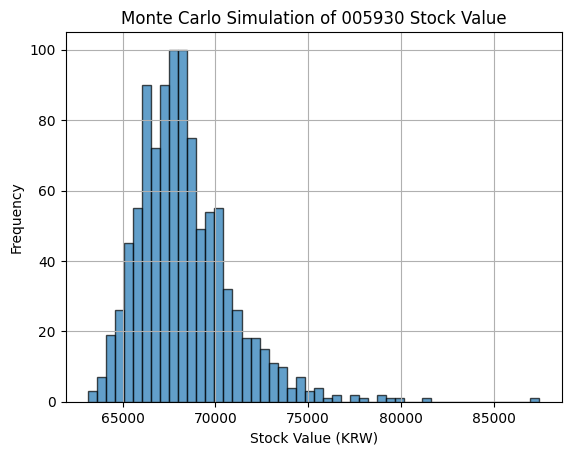

Mean Stock Value: 68327.26 KRW
Median Stock Value: 67963.14 KRW
Standard Deviation of Stock Value: 2546.10 KRW


,Stock Value
0,65800.893971
1,66468.801466
2,64076.998433
3,69155.626478
4,67520.174815
...,...
995,73400.704659
996,66355.940833
997,71361.096712
998,66484.624091


In [355]:
# Step4: DCF
asset1 = DCF(table, forecast, wacc, company)
asset1.pv_FCFF()
asset1.TV()
asset1.NOA_IBD(table)
stockvalue, table = asset1.EV()
asset1.monte_carlo_simulation()

In [149]:
class MonteCarlo:

    def __init__(self,):
        self.
        self.
        self.

'\nclass MonteCarlo:\n\n    def __init__(self,):\n        self.\n        self.\n        self.\n'


------------------------------------------------
자료의 소스는 FnGuide, 네이버금융, Yahoo Finance입니다.해당 사이트들에 필요한 정보가 누락되어있으면 valuation을 중단합니다.

{'매출액': [2796048.0, 3022314.0, 2589355.0], '매출원가': [1664113.0, 1900418.0, 1803886.0], '판관비': [615596.0, 688130.0, 719799.0], '영업이익': [374345.77499999997, 314480.35, 47610.75], '+유형자산상각비': [312852, 359521, 355324], '+무형자산상각비': [29622, 31556, 31341], '-Capex': [471221, 494304, 576113], '-dNwc': [0, 81947, 47304], 'FCFF': [245598.7749999999, 129306.34999999998, -189141.25], '참고용NWC': [330356, 412303, 459607]}
최근 3개년 FCFF(단위: 억)


,2021,2022,2023
매출액,2796048.000,3022314.00,2589355.00
매출원가,1664113.000,1900418.00,1803886.00
판관비,615596.000,688130.00,719799.00
영업이익,374345.775,314480.35,47610.75
+유형자산상각비,312852.000,359521.00,355324.00
+무형자산상각비,29622.000,31556.00,31341.00
-Capex,471221.000,494304.00,576113.00
-dNwc,0.000,81947.00,47304.00
FCFF,245598.775,129306.35,-189141.25
참고용NWC,330356.000,412303.00,459607.00


첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음
 
각 항목들이 다음의 수치를 기반으로 추정됩니다.

1. 매출-연평균 매출성장률    :-4.0%
2. 매출원가-평균 매출원가율   :64.02%
3. 판매관리비-평균 판관비율   :24.19%
4. 자본적지출-매출대비비중    :18.49%
5. 유형자산상각비-매출대비비중  :12.27%
6. 무형자산상각비-매출대비비중  :1.1%
7. 순운전자본-영업이익대비비중  :394.9%

__________________________________________________________________________________________
신규 추정치

1. 매출-연평균 매출성장률    :-4.0%
2. 매출원가-평균 매출원가율   :64.02%
3. 판매관리비-평균 판관비율   :24.19%
4. 자본적지출-매출대비비중    :18.49%
5. 유형자산상각비-매출대비비중  :12.27%
6. 무형자산상각비-매출대비비중  :1.1%
7. 순운전자본-영업이익대비비중  :394.9%
__________________________________________________________________________________________
추정 5개년 FCFF(단위: 억)


,2024F,2025F,2026F,2027F,2028F
매출액,2485780.800,2386349.600,2290895.60,2199259.800,2111289.400
매출원가,1591410.400,1527754.000,1466643.90,1407978.100,1351659.000
판관비,601421.000,577364.200,554269.60,532098.800,510814.900
영업이익,212388.025,203892.475,195736.95,187907.675,180390.875
+유형자산상각비,304981.500,292782.200,281070.90,269828.100,259035.000
+무형자산상각비,27458.800,26360.400,25306.00,24293.800,23322.000
-Capex,459517.700,441137.000,423491.50,406551.800,390289.800
-dNwc,379111.800,-33548.800,-32206.10,-30917.800,-29683.800
FCFF,-293801.200,115446.900,110828.40,106395.600,102141.900


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Rf : 무위험 수익률
한국 국고채 5년 평균 수익률: 2.29%

Rm : 시장 수익률
KOSPI 5년 평균 수익률: 7.5%

Beta : 회사주가와 시장지수의 상관계수
Leverd Beta: 1.0214211621226472

>>>>Re(자기자본비용) = Rf + Beta(Rm-Rf)

 


{'grade': 'AAA', 'date': '2004/05/25'}
         5년
국고채    3.15
AAA    3.48
AA+    3.55
AA     3.61
AA-    3.72
A+     4.53
A      4.98
A-     5.58
BBB+   7.53
BBB    8.58
BBB-  10.00
Kd(타인자본비용)
AAA 등급 회사채 수익률: 3.48%

Ke(자기자본비용): 7.612%

WACC = Re*자본비율 + Ke(1-tax)*부채비율
WACC(가중평균자본비용): 6.54%
__________________________________________________________________________________________


PV of FCFF 민감도 분석 테이블


,4.54%,5.54%,6.54%,7.54%,8.54%
PV of FCFF,92473.8,83282.4,74562.6,66287.1,58430.5


WACC : 6.54%


영구성장률은 추정 마지막 년도 이후에 회사의 성장률입니다. 보통 0% ~ 2%가 적절한 값입니다.
__________________________________________________________________________________________

TV 및 PV of TV 민감도 분석 테이블
WACC : 6.54% 영구성장률: 2.0%


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,2579082.97,2063266.38,1719388.65,1473761.70,1289541.49
1.5%,3455800.95,2591850.71,2073480.57,1727900.48,1481057.55
2.0%,3472824.60,2604618.45,2083694.76,1736412.30,1488353.40
2.5%,5234772.37,3489848.25,2617386.19,2093908.95,1744924.12
3.0%,5260307.85,3506871.90,2630153.92,2104123.14,1753435.95


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,2065435.87,1575538.87,1252478.4,1024559.38,855946.52
1.5%,2767547.74,1979173.21,1510414.55,1201236.7,983067.28
2.0%,2781180.98,1988922.83,1517855.01,1207154.12,987909.98
2.5%,4192221.32,2664896.6,1906619.35,1455685.85,1158211.45
3.0%,4212671.19,2677896.1,1915919.93,1462786.75,1163861.27


__________________________________________________________________________________________
회사 가치(단위: 억)


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,2157909.67,1658821.27,1327041.0,1090846.48,914377.02
1.5%,2860021.54,2062455.61,1584977.15,1267523.8,1041497.78
2.0%,2873654.78,2072205.23,1592417.61,1273441.22,1046340.48
2.5%,4284695.12,2748179.0,1981181.95,1521972.95,1216641.95
3.0%,4305144.99,2761178.5,1990482.53,1529073.85,1222291.77


회사의 자산 가치(단위: 억)


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,4609331.67,4110243.27,3778463.0,3542268.48,3365799.02
1.5%,5311443.54,4513877.61,4036399.15,3718945.8,3492919.78
2.0%,5325076.78,4523627.23,4043839.61,3724863.22,3497762.48
2.5%,6736117.12,5199601.0,4432603.95,3973394.95,3668063.95
3.0%,6756566.99,5212600.5,4441904.53,3980495.85,3673713.77


회사의 주가 가치(단위: 원)


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,77211,68851,63293,59337,56381
1.5%,88972,75612,67614,62296,58510
2.0%,89201,75775,67739,62395,58591
2.5%,112837,87099,74251,66558,61444
3.0%,113179,87316,74407,66677,61539


DCF평가법을 통한 005930의 주가는 67739원 입니다.



[*********************100%%**********************]  1 of 1 completed

__________________________________________________________________________________________
전일 종가는 87100.0원 입니다.


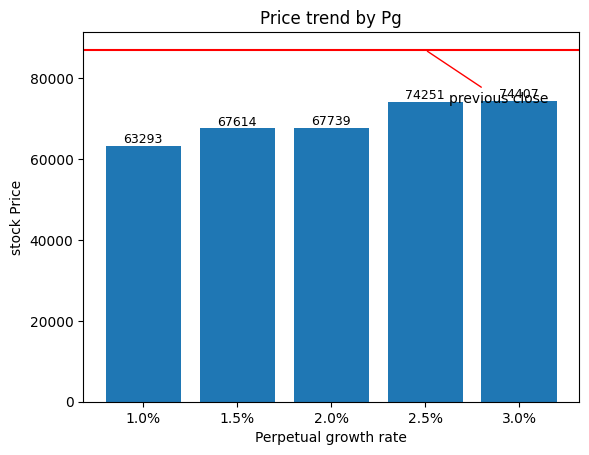

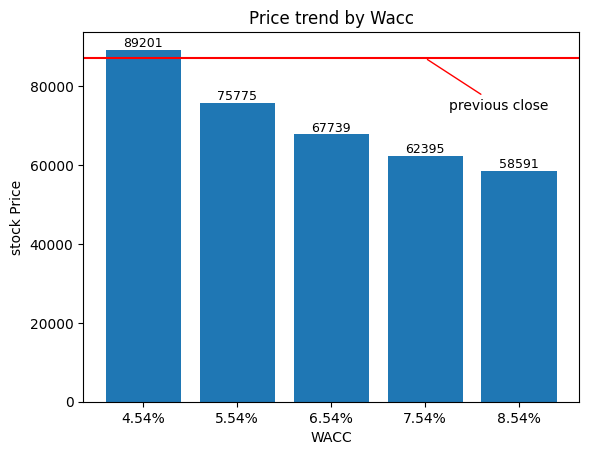

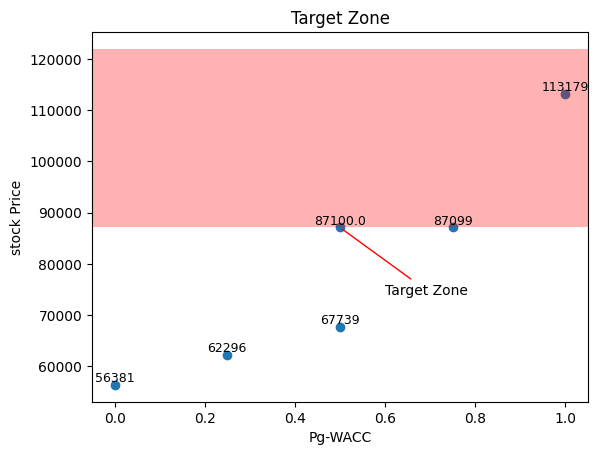

#3번 그래프: x축 진행방향으로 갈수록 pg와 wacc 격차가 축소됨


산출된 주가 - 현재 주가 = -19361.0
potentail = -22.23%
최종 의견: Sell

현재 가정하에 미래 현금흐름이 부족합니다.

수익성 개선이 필요합니다. 매출원가율, 판관비율을 줄일 필요가 있습니다.
재고자산 회전율을 높이고 매출채권 비중을 낮춰야합니다. 또 미지급금을 줄여서 최종적으로 NWC를 낮춰야합니다.

실행시간: 14.232548952102661
------------------------------------------------



In [150]:
import time

def checkTime(func):
    def new_func(*args):
        print("\n------------------------------------------------")
        start = time.time()
        func(*args)
        print("\n실행시간:",time.time()-start)
        print("------------------------------------------------\n")
    return new_func

@checkTime
def do_valuation():
    #try:
    # Step1 : loading F/S
    FS1_tables = load_FS()
    company = FS1_tables[0]
    IS = FS1_tables[1]
    BS = FS1_tables[2]
    CF = FS1_tables[3]

    # Preprocessing
    asset1 = step1(company, IS, BS, CF)
    tax = asset1.Basic_IS()
    asset1.Basic_CF()
    asset1.Dnwc()
    asset1.FCFF()
    fcff_table = asset1.mktable()

    # Step2 : Forecasting
    asset1 = step2(fcff_table, tax)
    asset1.ratios()
    asset1.Assume()
    forecast = asset1.forecast()

    # Step3 : WACC
    asset1 = WACC(company, BS, tax)
    asset1.risk_free_rate()
    asset1.market_risk_premium()
    asset1.beta()
    asset1.cost_debt()
    wacc = asset1.wacc()

    # Step4: DCF
    asset1 = DCF(forecast, wacc, company)
    asset1.pv_FCFF()
    asset1.TV()
    asset1.NOA_IBD(BS)
    stockvalue, table = asset1.EV()
    
    # Step5: Basic Analysis
    asset1 = analysis(company, stockvalue, BS, forecast, table)
    asset1.today_stockprice()
    asset1.visualization()
    cons = asset1.concensus()
    asset1.advise()

    # Step6: MonteCarlo Simulation --> terminal value를 확률변수로 두고 해보자

       
    #except:
        #print("\n데이터를 불러오는데 문제가 있습니다. 보통 필요한 정보가 누락된 경우에 발생합니다가 있습니다. 혹은 종목 코드를 다시 입력해보십시오.")
    
   
if __name__ == "__main__":
    do_valuation()